# **DEBAGREE**

## **Descriptive Stats**

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_GitHub\\code\\faultana')

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
import gurobipy
from gurobipy import *

pd.options.mode.chained_assignment = None

In [3]:
from script_faultana_functions import filter_subreddit
from script_faultana_functions import aggregate_interactions_directed
from script_faultana_functions import get_counts_and_shares
from script_faultana_functions import find_max
from script_faultana_functions import build_undirected

In [4]:
# import labeled data
data = pd.read_csv("../../../data_debagree/data/LabeledData/labeled_data.csv")
data

,label,msg_id_parent,msg_id_child,submission_id,body_parent,body_child,submission_text,subreddit,author_parent,exact_time,author_child,datetime,agreement_fraction,individual_kappa
0,0,gfvmv5x,gfvmzei,kd0se4,So now that they have elected Biden how can we...,"They haven't, it is a contested election. The ...","Forensic Audit: ""We conclude that the Dominion...",Republican,guildarts15,1607998349,03-Oct,15/12/2020 02:12,1.000000,1.000000
1,2,gyn3we6,gyn4ruu,nfrunb,"Tlaib, your family is Hamas. Funded by Iran a ...",She was not truthful when she swore her oath o...,Biden and The Squad's Tlaib stage heated confr...,Republican,oppositeofoutside,1621387168,cmcolfax,19/05/2021 01:19,1.000000,1.000000
2,0,gbh1w5x,gbh2dxt,jpv1jr,Most Republicans are happy with Biden as he wi...,I'm not happy about it but I'm not going out a...,President-elect Biden is projected to win Penn...,Republican,Rpdaca,1604773521,elang7390,07/11/2020 18:25,1.000000,1.000000
3,0,fv8hp2o,fv9lbzd,hbf73b,What is going to happen with this trend is tha...,Shouldn't they only fire use their weapon unle...,Not even an issue of politics it’s wrong this ...,Republican,wiseways9999,1592511116,Hotelier83,18/06/2020 20:11,0.666667,0.333333
4,0,g8ahfgp,g8ahzwk,j8crnu,We gotta start normalizing defending ourselves...,Nah women are about equal rights now a days so...,Young man wearing MAGA hat attacked at school ...,Republican,jwymes44,1602308654,notaglock,10/10/2020 05:44,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42889,2,fpqh5kk,fpshofn,gez26f,"More fundamentally, Trump simply can't do the ...",Do you believe Pence would be an improvement? ...,Ezra Klein on Twitter--Donald Trump does not w...,democrats,p011t1c5,1588873646,Onearmplanche,07/05/2020 17:47,0.666667,0.333333
42890,1,fkqjayp,fkw48q9,fjvy9f,I hope USA finds the vaccine first. That shoul...,Given the good nature and intentions of vaccin...,"President Trump promised a fast vaccine, this ...",Republican,No555M,1584583111,superdmp,19/03/2020 01:58,0.666667,0.333333
42891,0,gbohwgc,gbou2hb,jqok2a,Is there a postcard mailing project? I did tha...,I did a search on Mobilize.us but i wasnt able...,Volunteer from home to help flip the senate. D...,democrats,wagonwheelwhat,1604896314,princesspeach722,09/11/2020 04:31,0.666667,0.333333
42892,1,ggrfp0s,ggrhkvu,kijy95,Comical. We had a $1200 package until the GOP ...,Never forget this 900 billion includes almost ...,"Nancy Pelosi calls for $2000 in direct checks,...",democrats,kmurph72,1608694630,sulkee,23/12/2020 03:37,0.666667,0.333333


**Columns:**

* label: indicates whether parent and child comment 
    * 2: agree
    * 1: neutral
    * 0: disagree

* msg_id_parent: the reddit identifier for the parent message
* msg_id_child: the reddit identifier for the child message
* submission_id: the reddit identifier for the submission
* body_parent: the text of the parent comment
* body_child : the text of the child comment
* submission_text: abbreviated submission text
* subreddit: subreddit name on which the interaction took place
* author_parent: reddit username of parent author
* exact_time : UTC timestamp of time when interaction occurred
* author_child: reddit username of child author
* datetime: datetime timestamp for when interaction occurred, formatted as YYYY-MM-DD HH:MM:SS
* agreement_fraction: the fraction of annotators that agree with the final label 
* individual_kappa: the Fleiss’ kappa for each annotation. Calculation of Fleiss’ kappa is taken from
appendix A.2 of [8].

***

### **Overall label counts and shares**

In [5]:
data['label'].value_counts()

print('overall')
get_counts_and_shares(data, 'label')

overall


,label,Count,%
0,0,16974,0.395720
1,2,14759,0.344081
2,1,11161,0.260200


### **Subreddit Stats**

In [6]:
subreddits = list(data.subreddit.unique())
subreddits

['Republican', 'Brexit', 'climate', 'BlackLivesMatter', 'democrats']

In [7]:
for subr in subreddits:

    df_temp = filter_subreddit(data, subr)

    print(subr, ":\n-----------------")
    print("Nr. of unique replies", len(list(df_temp['msg_id_child'].unique())))
    print("Nr. of unique comments", len(list(df_temp['msg_id_parent'].unique())))
    print("Nr. of unique submissions", len(list(df_temp['submission_id'].unique())))
    print("Nr. of interactions", len(df_temp))
    print("\n")
    print(get_counts_and_shares(df_temp, 'label'))
    print("\n")

Republican :
-----------------
Nr. of unique replies 9823
Nr. of unique comments 7143
Nr. of unique submissions 3129
Nr. of interactions 9823


  label  Count         %
0   neg   3997  0.406902
1   pos   3405  0.346635
2   neu   2421  0.246462


Brexit :
-----------------
Nr. of unique replies 15745
Nr. of unique comments 12363
Nr. of unique submissions 8172
Nr. of interactions 15745


  label  Count         %
0   neg   6548  0.415878
1   neu   4599  0.292093
2   pos   4598  0.292029


climate :
-----------------
Nr. of unique replies 5773
Nr. of unique comments 4391
Nr. of unique submissions 2797
Nr. of interactions 5773


  label  Count         %
0   neg   2345  0.406201
1   pos   1829  0.316820
2   neu   1599  0.276979


BlackLivesMatter :
-----------------
Nr. of unique replies 1929
Nr. of unique comments 1548
Nr. of unique submissions 936
Nr. of interactions 1929


  label  Count         %
0   pos    864  0.447900
1   neg    632  0.327631
2   neu    433  0.224469


democrats :
---

### **Directed Interactions**

In [8]:
for subr in subreddits:

    df_temp = filter_subreddit(data, subr)
    edges_temp = aggregate_interactions_directed(df_temp)

    print(subr, ":\n-----------------")
    print("Nr. of user-pairs", len(edges_temp))
    print("Share of one-time interactions:", get_counts_and_shares(edges_temp, '#interact')["%"][0])
    print("\n")

Republican :
-----------------
Nr. of user-pairs 9726
Share of one-time interactions: 0.9938309685379395


Brexit :
-----------------
Nr. of user-pairs 12778
Share of one-time interactions: 0.858193770543121


climate :
-----------------
Nr. of user-pairs 5652
Share of one-time interactions: 0.9853149327671621


BlackLivesMatter :
-----------------
Nr. of user-pairs 1895
Share of one-time interactions: 0.9894459102902374


democrats :
-----------------
Nr. of user-pairs 9494
Share of one-time interactions: 0.9895723614914683




### **Undirected Network**

In [9]:
for subr in subreddits:

    df_temp = filter_subreddit(data, subr)
    edges_temp = aggregate_interactions_directed(df_temp)
    
    print(subr, ":\n-----------------")
    net_temp = build_undirected(edges_temp)

    
    print("Nr. of user-pairs", len(net_temp))
    print(get_counts_and_shares(net_temp, "interact"))
    print(get_counts_and_shares(net_temp, 'final_edge_num'))
    print("\n")

Republican :
-----------------
Nr. of bi-directional relations: 10
Nr. of agreeing bi-directional relations: 9
Nr. of disagreeing bi-directional relations: 1
Nr. of uni-directional relations: 9706


c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_GitHub\code\faultana\script_faultana_functions.py:560: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bi['final_edge_num'] = df_bi['final_edge'].replace({'neg' : -1, 'amb' : 0, 'pos' : 1})
c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_GitHub\code\faultana\script_faultana_functions.py:581: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_uni['final_edge_num'] = df_uni['final_edge'].replace({'neg' : -1, 'amb' : 0, 'pos' : 1})


Nr. of user-pairs 9716
   interact  Count         %
0       1.0   9647  0.992898
1       2.0     63  0.006484
2       3.0      6  0.000618
   final_edge_num  Count         %
0               1   5752  0.592013
1              -1   3946  0.406134
2               0     18  0.001853


Brexit :
-----------------
Nr. of bi-directional relations: 974
Nr. of agreeing bi-directional relations: 451
Nr. of disagreeing bi-directional relations: 523


c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_GitHub\code\faultana\script_faultana_functions.py:560: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bi['final_edge_num'] = df_bi['final_edge'].replace({'neg' : -1, 'amb' : 0, 'pos' : 1})


Nr. of uni-directional relations: 10830


c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_GitHub\code\faultana\script_faultana_functions.py:581: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_uni['final_edge_num'] = df_uni['final_edge'].replace({'neg' : -1, 'amb' : 0, 'pos' : 1})
c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_GitHub\code\faultana\script_faultana_functions.py:560: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bi['final_edge_num'] = df_bi['final_edge'].replace({'neg' : -1, 'amb' : 0, 'pos' : 1})


Nr. of user-pairs 11804
    interact  Count         %
0        1.0   9598  0.813114
1        2.0   1454  0.123179
2        3.0    408  0.034565
3        4.0    150  0.012708
4        5.0     66  0.005591
5        6.0     38  0.003219
6        7.0     27  0.002287
7        8.0     22  0.001864
8        9.0     13  0.001101
9       10.0     12  0.001017
10      11.0      4  0.000339
11      12.0      4  0.000339
12      13.0      3  0.000254
13      14.0      2  0.000169
14      16.0      1  0.000085
15      21.0      1  0.000085
16      17.0      1  0.000085
   final_edge_num  Count         %
0               1   6642  0.562691
1              -1   4476  0.379193
2               0    686  0.058116


climate :
-----------------
Nr. of bi-directional relations: 32
Nr. of agreeing bi-directional relations: 17
Nr. of disagreeing bi-directional relations: 15
Nr. of uni-directional relations: 5588


c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_GitHub\code\faultana\script_faultana_functions.py:581: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_uni['final_edge_num'] = df_uni['final_edge'].replace({'neg' : -1, 'amb' : 0, 'pos' : 1})
c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_GitHub\code\faultana\script_faultana_functions.py:560: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bi['final_edge_num'] = df_bi['final_edge'].replace({'neg' : -1, 'amb' : 0, 'pos' : 1})
c:\Users\3leso\Documents\Elena

Nr. of user-pairs 5620
   interact  Count         %
0       1.0   5513  0.980961
1       2.0     90  0.016014
2       3.0     11  0.001957
3       4.0      3  0.000534
4       5.0      2  0.000356
5       6.0      1  0.000178
   final_edge_num  Count         %
0               1   3322  0.591103
1              -1   2262  0.402491
2               0     36  0.006406


BlackLivesMatter :
-----------------
Nr. of bi-directional relations: 2
Nr. of agreeing bi-directional relations: 2
Nr. of disagreeing bi-directional relations: 0
Nr. of uni-directional relations: 1891
Nr. of user-pairs 1893
   interact  Count         %
0       1.0   1871  0.988378
1       2.0     21  0.011094
2       3.0      1  0.000528
   final_edge_num  Count         %
0               1   1270  0.670893
1              -1    618  0.326466
2               0      5  0.002641


democrats :
-----------------
Nr. of bi-directional relations: 29
Nr. of agreeing bi-directional relations: 18
Nr. of disagreeing bi-directional rela

c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_GitHub\code\faultana\script_faultana_functions.py:581: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_uni['final_edge_num'] = df_uni['final_edge'].replace({'neg' : -1, 'amb' : 0, 'pos' : 1})


***

### **Text Lengths**

In [28]:
texts = data[['label', 'body_child', 'body_parent', 'subreddit']]
texts

texts['child_tokens'] =  texts['body_child'].apply(str.split)
texts['parent_tokens'] =  texts['body_parent'].apply(str.split)

texts['child_length'] = texts['child_tokens'].apply(len)
texts['parent_length'] = texts['parent_tokens'].apply(len)

In [29]:
texts

,label,body_child,body_parent,subreddit,child_tokens,parent_tokens,child_length,parent_length
0,0,"They haven't, it is a contested election. The ...",So now that they have elected Biden how can we...,Republican,"[They, haven't,, it, is, a, contested, electio...","[So, now, that, they, have, elected, Biden, ho...",19,36
1,2,She was not truthful when she swore her oath o...,"Tlaib, your family is Hamas. Funded by Iran a ...",Republican,"[She, was, not, truthful, when, she, swore, he...","[Tlaib,, your, family, is, Hamas., Funded, by,...",34,53
2,0,I'm not happy about it but I'm not going out a...,Most Republicans are happy with Biden as he wi...,Republican,"[I'm, not, happy, about, it, but, I'm, not, go...","[Most, Republicans, are, happy, with, Biden, a...",21,18
3,0,Shouldn't they only fire use their weapon unle...,What is going to happen with this trend is tha...,Republican,"[Shouldn't, they, only, fire, use, their, weap...","[What, is, going, to, happen, with, this, tren...",24,99
4,0,Nah women are about equal rights now a days so...,We gotta start normalizing defending ourselves...,Republican,"[Nah, women, are, about, equal, rights, now, a...","[We, gotta, start, normalizing, defending, our...",31,36
...,...,...,...,...,...,...,...,...
42889,2,Do you believe Pence would be an improvement? ...,"More fundamentally, Trump simply can't do the ...",democrats,"[Do, you, believe, Pence, would, be, an, impro...","[More, fundamentally,, Trump, simply, can't, d...",35,94
42890,1,Given the good nature and intentions of vaccin...,I hope USA finds the vaccine first. That shoul...,Republican,"[Given, the, good, nature, and, intentions, of...","[I, hope, USA, finds, the, vaccine, first., Th...",39,16
42891,0,I did a search on Mobilize.us but i wasnt able...,Is there a postcard mailing project? I did tha...,democrats,"[I, did, a, search, on, Mobilize.us, but, i, w...","[Is, there, a, postcard, mailing, project?, I,...",15,13
42892,1,Never forget this 900 billion includes almost ...,Comical. We had a $1200 package until the GOP ...,democrats,"[Never, forget, this, 900, billion, includes, ...","[Comical., We, had, a, $1200, package, until, ...",72,23


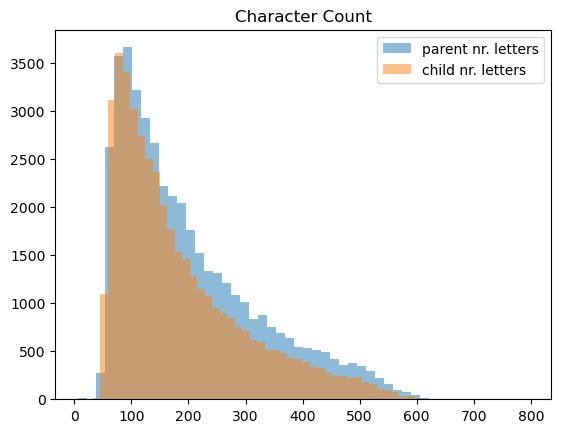

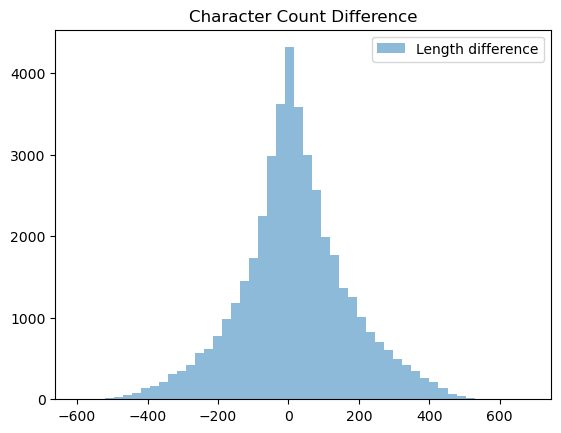

In [33]:
def compare_text_len(df, col_1, col_2, col_1_label, col_2_label, title_1, title_2):

    df["comm_len"] = df[col_1].apply(len)
    df["reply_len"] = df[col_2].apply(len)
    df['len_diff'] = df["comm_len"] - df["reply_len"]
    df

    plt.hist(df['comm_len'], bins=50, label=col_1_label, alpha=0.5)
    plt.hist(df['reply_len'], bins=50, label=col_2_label, alpha=0.5)
    plt.title(title_1)
    plt.legend(loc='best')
    plt.show()
    
    
    
    plt.hist(df['len_diff'], bins=50, label="Length difference", alpha=0.5)
    plt.title(title_2)
    plt.legend(loc='best')
    plt.show()


compare_text_len(data, "body_parent", "body_child", "parent nr. letters", "child nr. letters", 
                 title_1 = "Character Count", title_2 = "Character Count Difference")

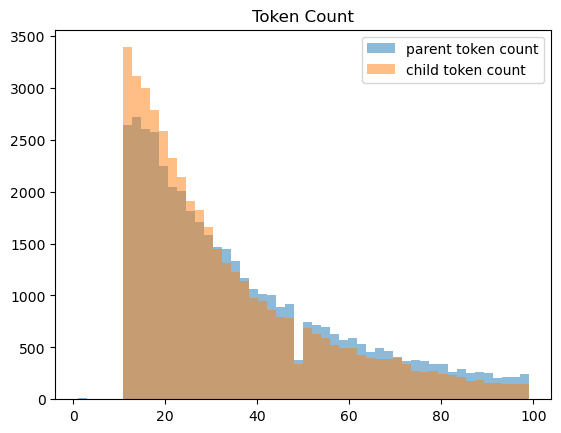

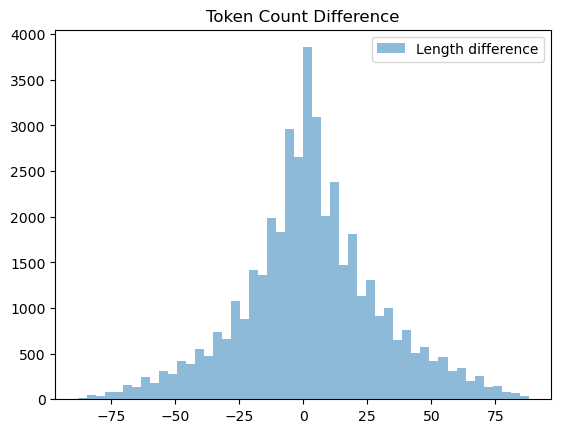

In [ ]:
compare_text_len(texts, "parent_tokens", "child_tokens", "parent token count", "child token count", 
                 title_1 = "Token Count", title_2 = "Token Count Difference")

### **Correlation of parent and child text lengths** 

<Axes: xlabel='parent_length', ylabel='child_length'>

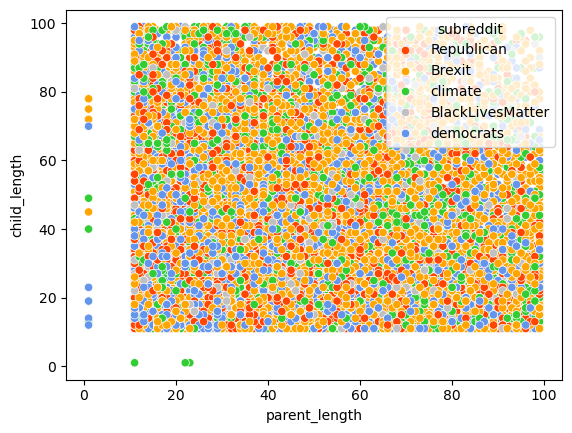

In [50]:
subreddits
color_dict = {'Republican' : 'orangered', 'Brexit' : 'orange', 'climate' : 'limegreen', 'BlackLivesMatter' : 'silver', 'democrats' : 'cornflowerblue'}

sns.scatterplot(data = texts, x = 'parent_length', y = 'child_length', hue = 'subreddit', palette=color_dict)

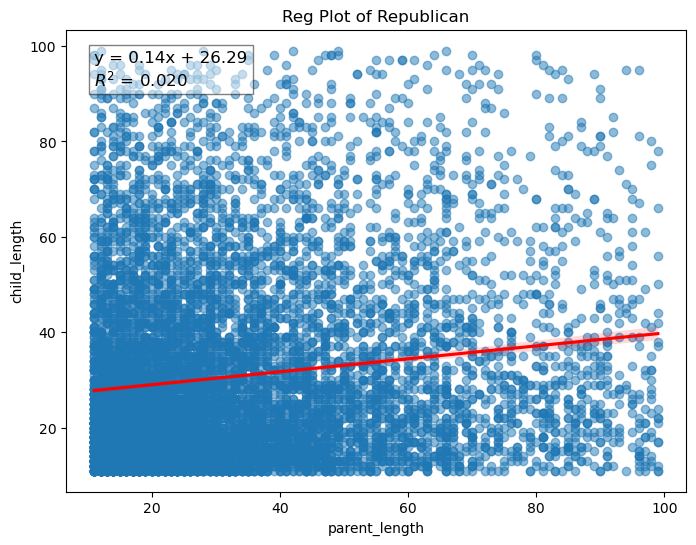

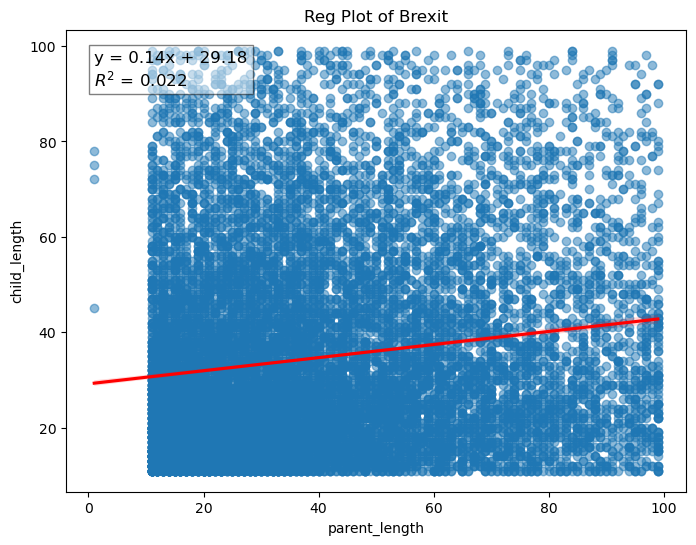

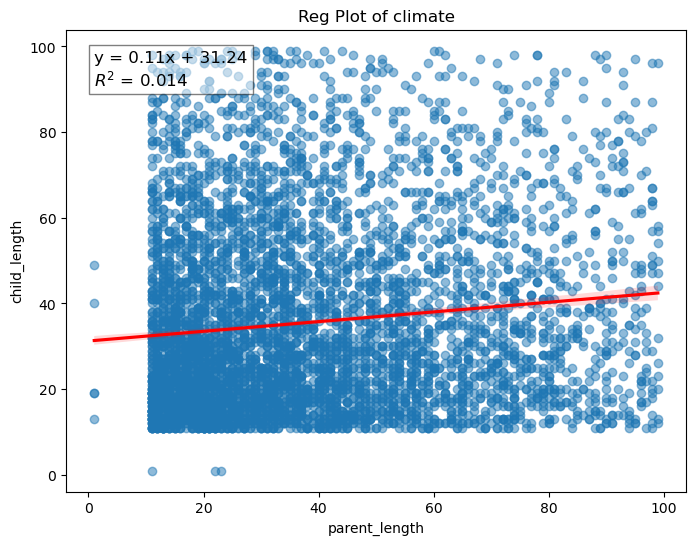

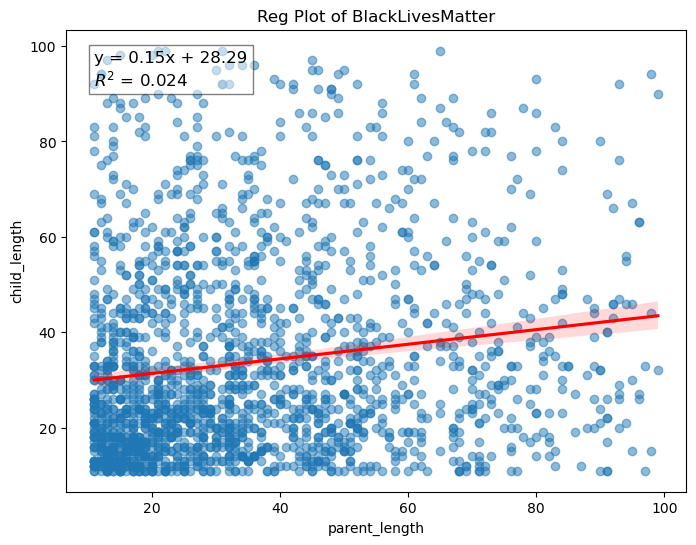

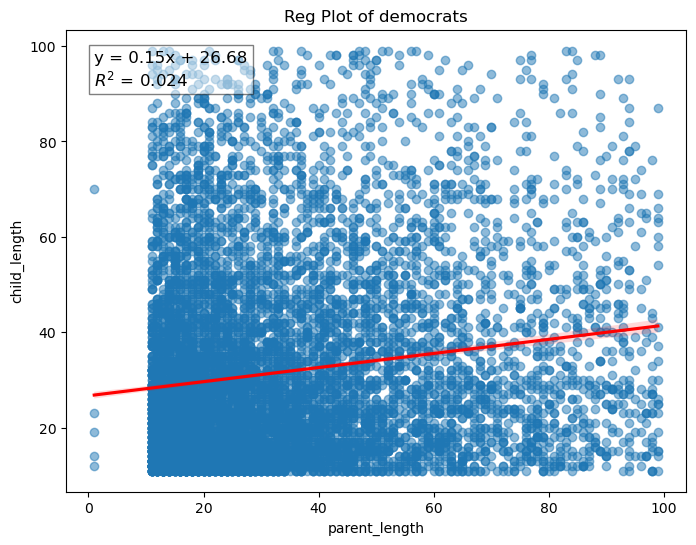

In [66]:
import scipy.stats as stats

def check_correlations(df):

    for subr in df['subreddit'].unique():
        df_temp = df[df['subreddit'] == subr]

        slope, intercept, r_value, p_value, std_err = stats.linregress(df_temp['parent_length'], df_temp['child_length'])
        
        # Create the regression plot
        plt.figure(figsize=(8, 6))
        sns.regplot(data=df_temp, x='parent_length', y='child_length', line_kws={"color": "red"}, scatter_kws={"alpha" : 0.5})
        
        # Add the regression equation and R² value
        equation = f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.3f}"
        plt.text(
            x=np.min(df_temp['parent_length']), 
            y=np.max(df_temp['child_length']), 
            s=equation, 
            fontsize=12, 
            verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.5)
        )

        plt.title(f"Reg Plot of {subr}")
        plt.show()

check_correlations(texts)